# YOLOv5 on CBIS-DDSM (Calcification)

This notebook prepares YOLOv5 dataset folders from your cleaned CSVs and ROI masks, writes label files in YOLO format, creates a dataset YAML, and launches training.

In [4]:
%pip install ultralytics
%pip install opencv-python
%pip install pandas
%pip install matplotlib
%pip install tqdm
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from pathlib import Path

# Base project dir, only calcificaton sets are used 
BASE_DIR = Path('./')
CSV_TRAIN = BASE_DIR / "cbis-ddsm-breast-cancer-image-dataset" / "csv" / "calc_case_description_train_set_cleaned.csv"

# YOLO dataset root
YOLO_ROOT = BASE_DIR / "yolo_cbis_ddsm"
IMAGES_DIR = YOLO_ROOT / "images"
LABELS_DIR = YOLO_ROOT / "labels"

# Split names
SPLITS = ["train", "val"]
LABEL_MODE = "dual"

os.makedirs(YOLO_ROOT, exist_ok=True)
for s in SPLITS:
    (IMAGES_DIR / s).mkdir(parents=True, exist_ok=True)
    (LABELS_DIR / s).mkdir(parents=True, exist_ok=True)


In [3]:
# Utilities to convert mask -> bbox and write YOLO labels
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm


def read_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # keep only required columns
    needed = [
        "image file path",
        "ROI mask file path",
        "label",
    ]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    # Drop rows without mask path
    df = df.dropna(subset=["ROI mask file path"]).reset_index(drop=True)
    return df


def path_from_csv(base_dir: Path, csv_path_str: str) -> Path:
    # CSV stores like ./cbis-ddsm-breast-cancer-image-dataset/jpeg/.../file.jpg
    p = (base_dir / csv_path_str.strip("./")).resolve()
    return p


def mask_to_bboxes(mask_path: Path) -> list:
    # Read as grayscale
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []
    # Binarize
    _, binm = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Find connected components or contours
    contours, _ = cv2.findContours(binm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < 2 or h < 2:
            continue
        bboxes.append((x, y, w, h))
    return bboxes


def yolo_bbox(x, y, w, h, img_w, img_h):
    xc = (x + w / 2) / img_w
    yc = (y + h / 2) / img_h
    ww = w / img_w
    hh = h / img_h
    return xc, yc, ww, hh


def choose_class_id(label_value: int) -> int:
    return 1 if int(label_value) == 1 else 0  # benign=0, malignant=1


def convert_rows_to_yolo(df: pd.DataFrame, split_name: str):
    split_img_dir = IMAGES_DIR / split_name
    split_lbl_dir = LABELS_DIR / split_name

    written = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = path_from_csv(BASE_DIR, row["image file path"])  # image path is relative to BASE_DIR
        mask_path = path_from_csv(BASE_DIR, row["ROI mask file path"])  # ROI mask path
        if not img_path.exists() or not mask_path.exists():
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img_h, img_w = img.shape[:2]
        bboxes = mask_to_bboxes(mask_path)
        if len(bboxes) == 0:
            continue
        # Prepare label lines
        label_lines = []
        class_id = choose_class_id(row["label"])
        for (x, y, w, h) in bboxes:
            xc, yc, ww, hh = yolo_bbox(x, y, w, h, img_w, img_h)
            label_lines.append(f"{class_id} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}")
        # Copy/link image and write label
        dest_img = split_img_dir / img_path.name
        dest_lbl = split_lbl_dir / (img_path.stem + ".txt")
        if str(img_path.resolve()) != str(dest_img.resolve()):
            # copy image
            cv2.imwrite(str(dest_img), img)
        with open(dest_lbl, "w", encoding="utf-8") as f:
            f.write("\n".join(label_lines))
        written += 1
    print(f"{split_name}: wrote {written} images+labels")



In [4]:
# Build splits and convert
from sklearn.model_selection import train_test_split

train_df = read_csv(CSV_TRAIN)

# Build val from train
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["label"])

convert_rows_to_yolo(train_df, "train")
convert_rows_to_yolo(val_df, "val")

100%|██████████| 1391/1391 [02:18<00:00, 10.07it/s]


train: wrote 1389 images+labels


100%|██████████| 155/155 [00:15<00:00,  9.84it/s]

val: wrote 155 images+labels


In [ ]:
# Write dataset YAML
import yaml

names = ["benign", "malignant"]

yaml_dict = {
    "path": str(YOLO_ROOT),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": names,
    "nc": len(names),
}

yaml_path = BASE_DIR / "cbis_ddsm.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(yaml_dict, f, sort_keys=False)
print("Wrote:", yaml_path)
print(yaml.safe_dump(yaml_dict, sort_keys=False))

Wrote: C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine Learning\Prototype - Copy\cbis_ddsm.yaml
path: C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine
  Learning\Prototype - Copy\yolo_cbis_ddsm
train: images/train
val: images/val
test: images/test
names:
- benign
- malignant
nc: 2



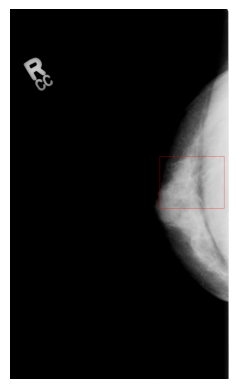

In [ ]:
# Visualisae a sample picture with bounding boxes -- focused on ROI masked
import random
import matplotlib.pyplot as plt

any_txts = list((LABELS_DIR / "train").glob("*.txt"))
if any_txts:
    lbl_path = random.choice(any_txts)
    img_path = IMAGES_DIR / "train" / (lbl_path.stem + ".jpg")
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    with open(lbl_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, xc, yc, ww, hh = map(float, parts)
            x = int((xc - ww/2) * w)
            y = int((yc - hh/2) * h)
            bw = int(ww * w)
            bh = int(hh * h)
            cv2.rectangle(img, (x, y), (x + bw, y + bh), (255, 0, 0), 2)
    plt.imshow(img)
    plt.axis('off')
else:
    print("No labels found to visualize.")



#### No ClAHE Processing done -- More YOLO models and CLAHE preprocessing is done is Colab (Refer to YOLO models file)
Ran a trail run in local machine to see estimate time (since Colab needed reupload of files, which took time)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov5s.yaml')
model.train(
    data=str(BASE_DIR / 'cbis_ddsm.yaml'),
    imgsz=448,
    epochs=100,
    batch=16,
    project=str(BASE_DIR / 'runs_ultralytics'),
    name=f'cbis_{LABEL_MODE}_scratch',
    exist_ok=True
)

Ultralytics 8.3.200  Python-3.12.7 torch-2.8.0+cpu CPU (AMD Ryzen 7 7840HS w/ Radeon 780M Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine Learning\Prototype - Copy\cbis_ddsm.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=448, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=cbis_dual_scratch, n

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020D0354D070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

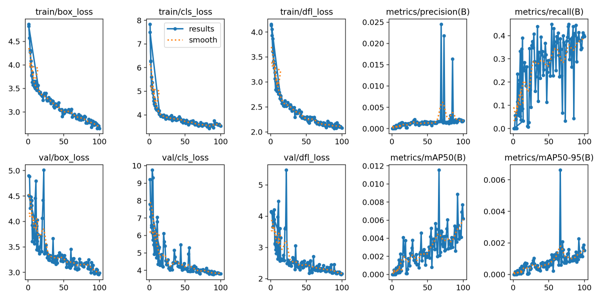

In [2]:

# Show a results.png only
from pathlib import Path
from PIL import Image
from IPython.display import display

runs_dir = BASE_DIR / 'runs_ultralytics'
run_candidates = sorted([p for p in runs_dir.glob('cbis_*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
save_dir = run_candidates[0]
res_img = save_dir / 'results.png'
if res_img.exists():
    im = Image.open(res_img).convert('RGB')
    im.thumbnail((600, 600))  # smaller display
    display(im)

In [ ]:
# Evaluate best model and display key metrics
from pathlib import Path
from ultralytics import YOLO

IMG_SIZE = 448

# Find the latest run that starts with 'cbis_'
runs_dir = BASE_DIR / 'runs_ultralytics'
run_candidates = sorted([p for p in runs_dir.glob('cbis_*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
if not run_candidates:
    raise FileNotFoundError(f'No run folders found in {runs_dir}. Train a model first.')
save_dir = run_candidates[0]
print('Using run:', save_dir)

# Load best weights if present, else last
weights_dir = save_dir / 'weights'
ckpt = weights_dir / 'best.pt'
if not ckpt.exists():
    ckpt = weights_dir / 'last.pt'
if not ckpt.exists():
    raise FileNotFoundError(f'No weights found in {weights_dir}')

model = YOLO(str(ckpt))
metrics = model.val(data=str(BASE_DIR / 'cbis_ddsm.yaml'), imgsz=IMG_SIZE, batch=2, workers=0, device='cpu')    # shows mAP, precision, recall, mAP = 0.0116, refer to csv for more
print('Results:', metrics.results_dict)
print('Plots saved under:', save_dir)



Using run: C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine Learning\Prototype - Copy\runs_ultralytics\cbis_dual_scratch
Ultralytics 8.3.200  Python-3.12.7 torch-2.8.0+cpu CPU (AMD Ryzen 7 7840HS w/ Radeon 780M Graphics)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2546.1723.7 MB/s, size: 1849.5 KB)
val: Scanning C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine Learning\Prototype - Copy\yolo_cbis_ddsm\labels\val.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 64.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 64/64 5.8it/s 11.1s0.1s
                   all        128        128    0.00173      0.397     0.0116    0.00663
                benign         78         78    0.00146      0.333     0.0194     0.0123
             malignant

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs_ultralytics/cbis_dual_scratch/weights/best.pt")

# Evaluate on the validation set
metrics = model.val()
print(metrics)  

Ultralytics 8.3.200  Python-3.12.7 torch-2.8.0+cpu CPU (AMD Ryzen 7 7840HS w/ Radeon 780M Graphics)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 886.5172.3 MB/s, size: 1963.7 KB)
val: Scanning C:\Users\rando\OneDrive - SIM - Singapore Institute of Management\Final Project\Machine Learning\Prototype - Copy\yolo_cbis_ddsm\labels\val.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 31.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 0.7it/s 11.1s1.4s
                   all        128        128    0.00173      0.397     0.0116    0.00663
                benign         78         78    0.00146      0.333     0.0194     0.0123
             malignant         50         50    0.00199       0.46     0.0038   0.000962
Speed: 0.4ms preprocess, 38.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved

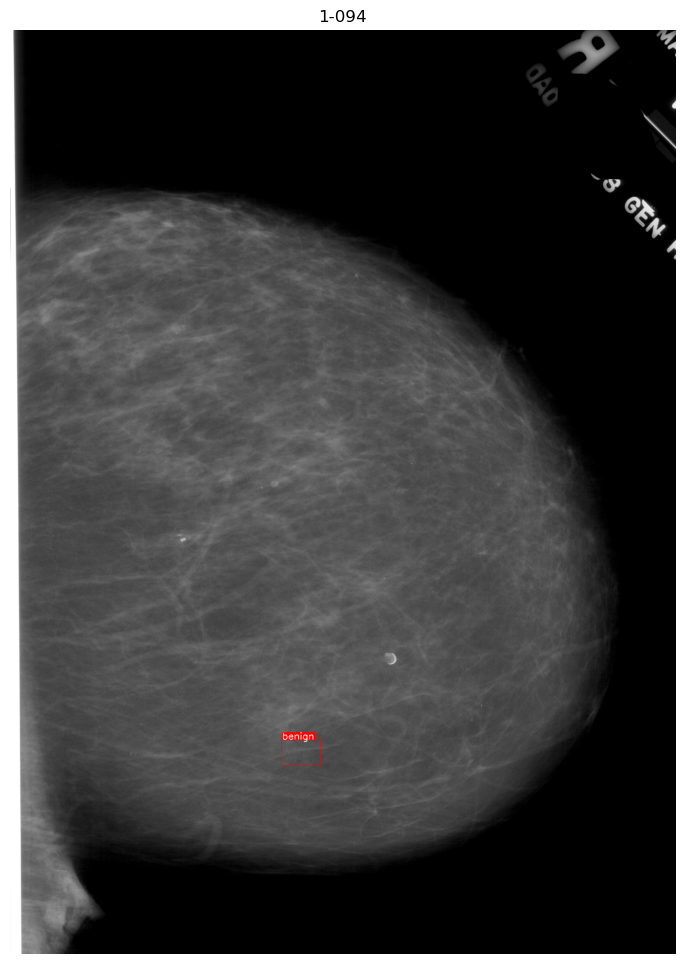

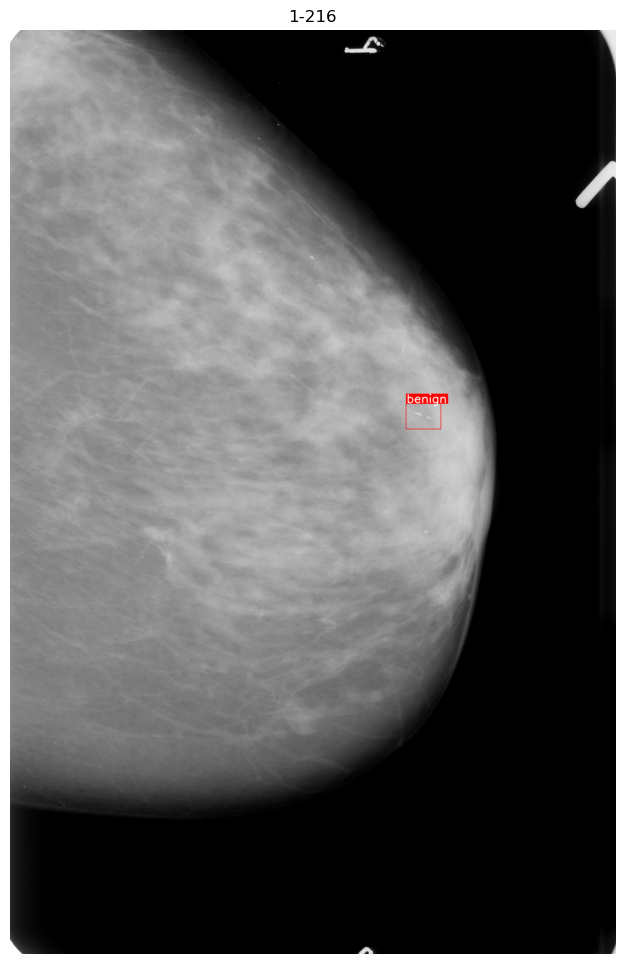

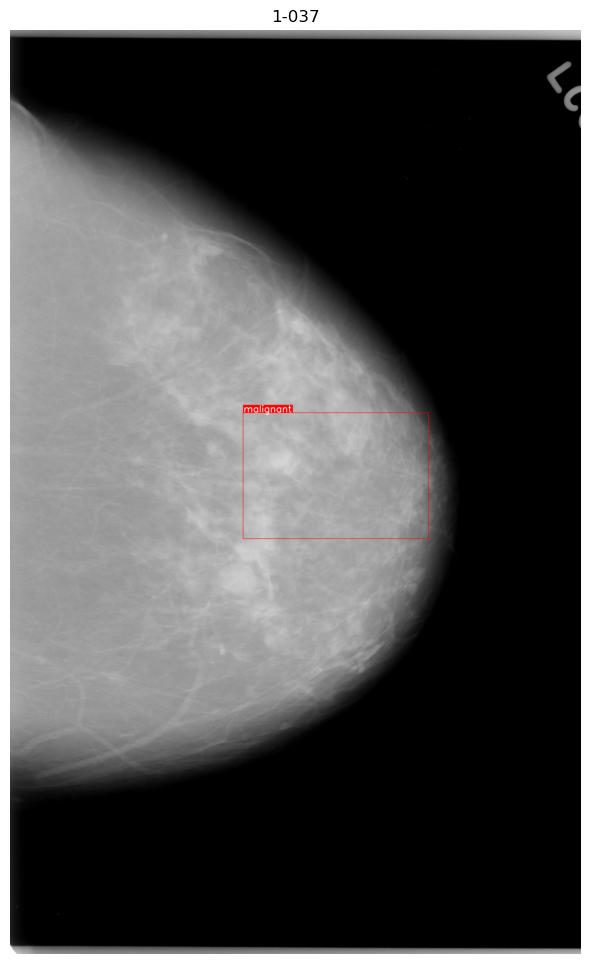

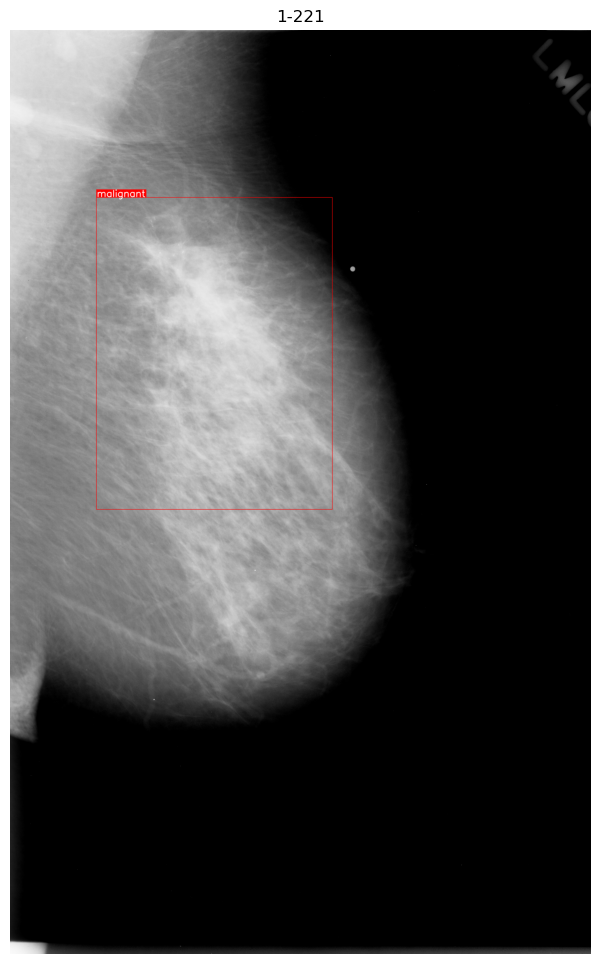

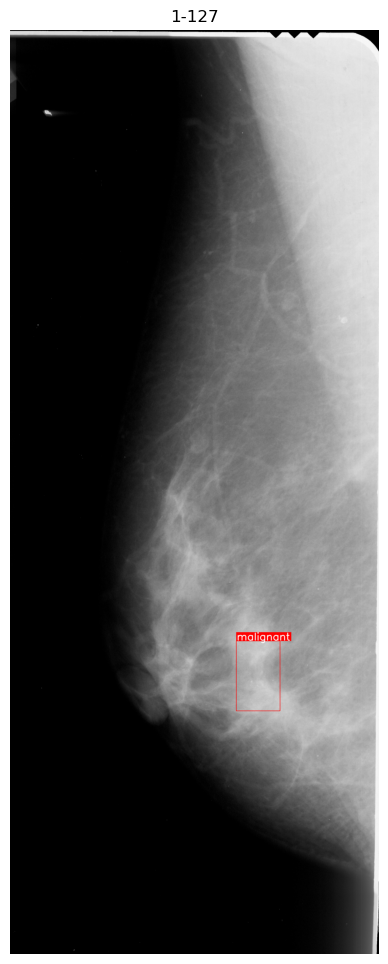

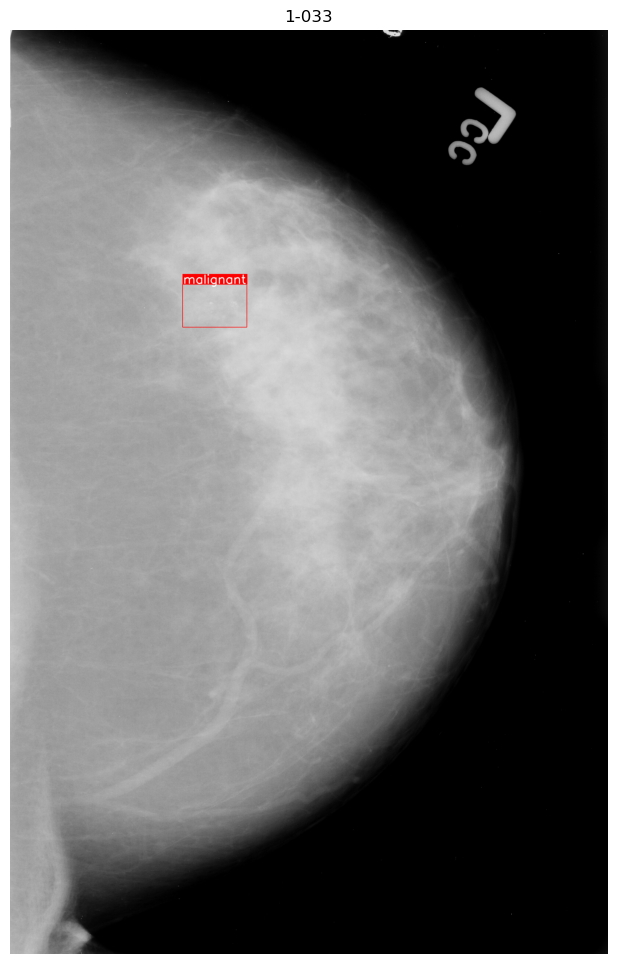

In [ ]:
# Show images with bounding boxes
import random
import matplotlib.pyplot as plt

class_names = ["benign", "malignant"]

val_labels = sorted(list((LABELS_DIR / 'val').glob('*.txt')))
if not val_labels:
    raise FileNotFoundError(f'No labels found in {LABELS_DIR / "val"}')

num_samples = 6
samples = random.sample(val_labels, k=min(num_samples, len(val_labels)))

for lbl in samples:
    img_path = (IMAGES_DIR / 'val' / (lbl.stem + '.jpg'))
    if not img_path.exists():
        # try png fallback if any
        png_path = img_path.with_suffix('.png')
        if png_path.exists():
            img_path = png_path
        else:
            continue
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # draw boxes from YOLO label
    with open(lbl, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(float(parts[0]))
            xc, yc, bw, bh = map(float, parts[1:])
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cls_name = class_names[cls_id] if 0 <= cls_id < len(class_names) else str(cls_id)
            # Labels for readability
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = max(0.8, min(2.0, 0.0015 * max(w, h)))  # scale with image size
            thickness = 3
            (tw, th), _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
            tx1, ty1 = x1, max(0, y1 - th - 6)
            tx2, ty2 = x1 + tw + 6, y1
            cv2.rectangle(img_rgb, (tx1, ty1), (tx2, ty2), (255, 0, 0), -1)
            cv2.putText(img_rgb, cls_name, (x1 + 3, y1 - 4), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    plt.figure(figsize=(12, 12))
    plt.title(lbl.stem)
    plt.imshow(img_rgb)
    plt.axis('off')
plt.show()



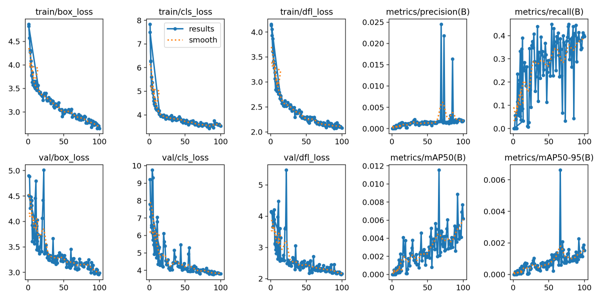